# Variational Autoencoder v PCA

In this notebook I want to show two types of dimensionality reduction for tabular data: PCA and Autoencoders.

I use the [wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) to show how Variational Autoencoder (VAE) with PyTorch on tabular data works and compare it to the classic PCA approach. I use the PCA/VAE to reduce the dimensionality of dataset, in this case don to 3 Variables (embeddings). I then plot the embeddings in a 3D graph to show how VAE is similar to a PCA but works in a non-linear way. 

## TODO

* safe model
* safe latent space

# Imports

In [87]:
# mamba create -n sdiv_spectra python=3.10
# mamba init
# mamba activate sdiv_spectra
# mamba install pytorch matplotlib scikit-learn pandas -c conda-forge

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import os
import csv
import random
from scipy.signal import savgol_filter
import rioxarray
import glob
import geopandas as gpd
import rasterio
import wandb

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Dataset & preprocessing

In [89]:
# path to dataset
#data_path = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/leaf_data/cabo-2018-2019-leaf-level-spectra_refonly.csv'
data_path = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/leaf_data/PROCESSED/2024_05_30_merged_leaf_dataset.csv'
folder_path = os.path.dirname(data_path)
#data_path = 'G:/My Drive/projects/project_sPectra/DB_47_Meta_EC.csv'

# path for model output
model_out_dir = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/dimred_leaf_v10_10lv/'
# check if model output directory exists and create it if not
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

In [90]:
df = pd.read_csv(data_path, sep=',', encoding = "ISO-8859-1")
df

/tmp/ipykernel_3220215/1082579224.py:1: DtypeWarning: Columns (2017) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=',', encoding = "ISO-8859-1")


,carbon_area,carbon_mass,Jmax,latin_genus,latin_species,leaf_mass_per_area,nitrogen_area,nitrogen_mass,Rd,Vcmax,...,calcium_area,copper_area,iron_area,potassium_area,magnesium_area,manganese_area,sodium_area,phosphorus_area,zinc_area,boron_area
0,6.605,454.9,147.996064,Vochysia,ferruginea,0.014520,0.240,16.5,1.084856,93.886044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.317,515.8,69.111812,Miconia,borealis,0.006431,0.161,25.0,1.356143,40.294967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.524,443.9,NaN,Vochysia,ferruginea,0.014697,0.219,14.9,0.878218,68.004240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.792,500.4,107.333091,Terminalia,amazonia,0.009576,0.193,20.2,0.843417,67.562622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.094,474.0,110.972181,Terminalia,amazonia,0.008636,0.179,20.7,0.688599,77.951305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6176,NaN,NaN,NaN,Tabebuia,heterophylla (DC.) Britton,0.007079,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6177,NaN,NaN,NaN,calophyllum,calaba,0.003522,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6178,NaN,NaN,NaN,calophyllum,calaba,0.008823,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6179,NaN,NaN,NaN,Alchornea,latifolia Sw.,0.004678,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add soil and climate data

### Prepare worldclim

In [91]:
# query files
clim_files = glob.glob('/mnt/gsdata/users/kattenborn/data/sdiv_spectra/earth_obseration_products/worldclim_res/**/*.tif', recursive=True)

# open all files 
clim = {os.path.basename(rf).split('deg_', 1)[-1].split('.tif', 1)[0]: rioxarray.open_rasterio(rf) for rf in clim_files}
clim.keys()

dict_keys(['bio_1', 'bio_12', 'bio_13-14', 'bio_15', 'bio_4', 'bio_7'])

In [92]:
# set all no data and inf vlaues to nan
clim["bio_1"].rio.write_nodata(3.400000e+38, inplace=True) 
clim = {key: raster.where((raster > -3.400000e+37) & (raster < 3.400000e+37) & (raster != -np.inf), other=np.nan) for key, raster in clim.items()}

/home/tk1112/miniconda3/envs/sdiv_spectra/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.4e+38) has been automatically changed to (3.3999999521443642e+38) to match the dtype of the data.
  warnings.warn(


### Prepare soilgrids

In [93]:
# query files
soil_files = glob.glob('/mnt/gsdata/users/kattenborn/data/sdiv_spectra/earth_obseration_products/soil_res/**/*.tif', recursive=True)

# filter keys to include any sand, soil but always 15-30cm
keywords = ["sand", "clay", "soc", "nitrogen"]
soil_files = [f for f in soil_files if any(word in f for word in keywords) and "15-30cm" in f]

# open all files 
soil = {os.path.basename(rf).split('deg_', 1)[-1].split('.tif', 1)[0]: rioxarray.open_rasterio(rf) for rf in soil_files}
soil.keys()

dict_keys(['clay_15-30cm_mean_0.01_deg', 'nitrogen_15-30cm_mean_0.01_deg', 'sand_15-30cm_mean_0.01_deg', 'soc_15-30cm_mean_0.01_deg'])

In [94]:
# browse through the layers of the soil rasterstack and set all values with -32768 to nan
soil = {key: raster.where((raster > -32768) & (raster != -np.inf), other=np.nan) for key, raster in soil.items()}

In [95]:
# replace empty cells in df['Longitude'] and df['Latitude'] with -25.3556 and -14.5704
df['longitude'].fillna(-25.3556, inplace=True)
df['latitude'].fillna(-14.5704, inplace=True)

/tmp/ipykernel_3220215/538101807.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['longitude'].fillna(-25.3556, inplace=True)
/tmp/ipykernel_3220215/538101807.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [96]:
# convert the sPlot data frame to a GeoDataFrame using geopandas (so we can extract the predictor values for each sPlot data point)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [97]:
# extract the pixel information at each sPlotOpen plot location
clim_extr = pd.DataFrame()
os.makedirs("temp", exist_ok=True)

for layer in clim.keys():
    clim[layer].rio.to_raster("temp/temp_raster.tif")
    with rasterio.open("temp/temp_raster.tif") as src:
        coords = [(x.x, x.y) for x in gdf.geometry]
        values = list(src.sample(coords))
        values = np.asarray(values)
        clim_extr[layer] = pd.DataFrame(values, columns=[layer])

In [98]:
# extract the pixel information at each sPlotOpen plot location
soil_extr = pd.DataFrame()
os.makedirs("temp", exist_ok=True)

for layer in soil.keys():
    soil[layer].rio.to_raster("temp/temp_raster.tif")
    with rasterio.open("temp/temp_raster.tif") as src:
        coords = [(x.x, x.y) for x in gdf.geometry]
        values = list(src.sample(coords))
        values = np.asarray(values)
        soil_extr[layer] = pd.DataFrame(values, columns=[layer])

In [99]:
# append the exracts to the df
df = pd.concat([df, clim_extr, soil_extr], axis=1)
df

,carbon_area,carbon_mass,Jmax,latin_genus,latin_species,leaf_mass_per_area,nitrogen_area,nitrogen_mass,Rd,Vcmax,...,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7,clay_15-30cm_mean_0.01_deg,nitrogen_15-30cm_mean_0.01_deg,sand_15-30cm_mean_0.01_deg,soc_15-30cm_mean_0.01_deg
0,6.605,454.9,147.996064,Vochysia,ferruginea,0.014520,0.240,16.5,1.084856,93.886044,...,26.630093,2345.364502,349.608887,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
1,3.317,515.8,69.111812,Miconia,borealis,0.006431,0.161,25.0,1.356143,40.294967,...,26.630093,2345.364502,349.608887,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
2,6.524,443.9,NaN,Vochysia,ferruginea,0.014697,0.219,14.9,0.878218,68.004240,...,26.630093,2345.364502,349.608887,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
3,4.792,500.4,107.333091,Terminalia,amazonia,0.009576,0.193,20.2,0.843417,67.562622,...,26.630093,2345.364502,349.608887,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
4,4.094,474.0,110.972181,Terminalia,amazonia,0.008636,0.179,20.7,0.688599,77.951305,...,26.630093,2345.364502,349.608887,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6176,NaN,NaN,NaN,Tabebuia,heterophylla (DC.) Britton,0.007079,NaN,NaN,NaN,NaN,...,25.456499,1886.382202,141.088882,31.369287,133.357498,11.169777,497.0,176.0,186.0,183.0
6177,NaN,NaN,NaN,calophyllum,calaba,0.003522,NaN,NaN,NaN,NaN,...,25.456499,1886.382202,141.088882,31.369287,133.357498,11.169777,497.0,176.0,186.0,183.0
6178,NaN,NaN,NaN,calophyllum,calaba,0.008823,NaN,NaN,NaN,NaN,...,25.456499,1886.382202,141.088882,31.369287,133.357498,11.169777,497.0,176.0,186.0,183.0
6179,NaN,NaN,NaN,Alchornea,latifolia Sw.,0.004678,NaN,NaN,NaN,NaN,...,25.456499,1886.382202,141.088882,31.369287,133.357498,11.169777,497.0,176.0,186.0,183.0


In [100]:
# write df to a file
df.to_csv(os.path.join(folder_path, 'mergeddata_leaf.csv'), index=False)
# define the new data path accordingly
data_path = os.path.join(folder_path, 'mergeddata_leaf.csv')

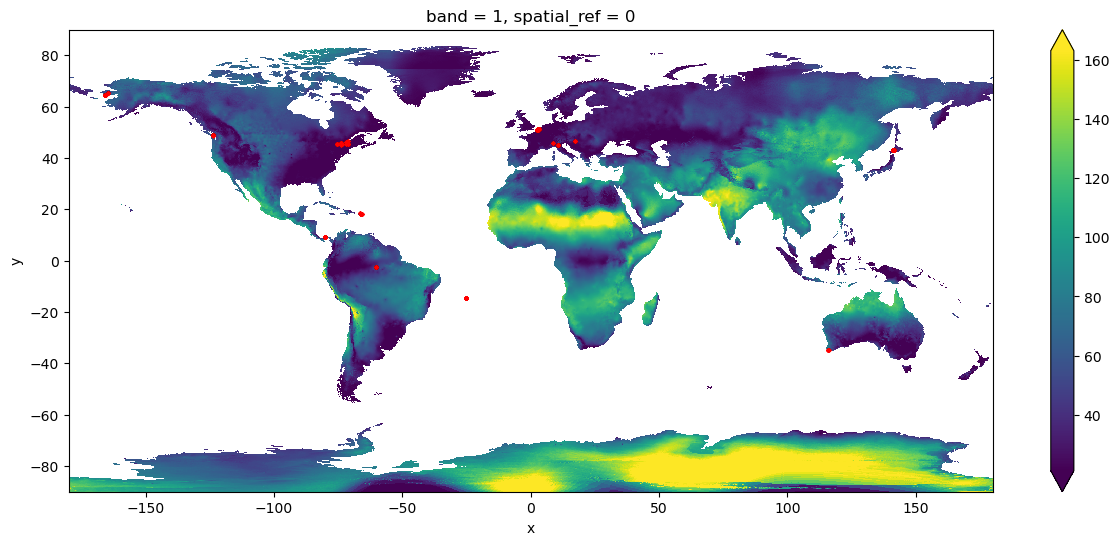

In [101]:
layer = "bio_15"

# overlay the raster with the points
plt.figure(figsize=(15, 6)) # Set the figure size
clim[layer].plot(vmin=clim[layer].quantile(0.05), vmax=clim[layer].quantile(0.95))
gdf.plot(ax=plt.gca(), color='r', markersize=2)
plt.show()

## Data loading function

In [102]:
def golay_spectra(df_base):
  db_copy = df_base.copy()
  # Apply Savitzky Golay filter to separate regions (to avoid smoothing in overly noisy regions)
  db_copy.loc[:,  '400':'2400'] = df_base.loc[:, '400':'2400'].apply(lambda row: savgol_filter(row, window_length=45, polyorder=1), axis=1).to_list()
  return db_copy

In [103]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',', low_memory=False)

    #### spectra processing ###
    wv = ['{}'.format(i) for i in range(400,2401)]
    df_base = df.loc[:, wv]

    ### eliminate negative and high values in the spectra ##
    other = df_base.copy()
    # other.columns = other.columns.astype('int')
    other[other<0] = np.nan
    #####Substitute high values with the mean of neighbour values
    other[other>1] = np.nan
    ### interpolate the nan values ###
    other = (other.ffill() + other.bfill())/2
    other = other.interpolate(method='linear',limit_area=None, axis=1, limit_direction='both')
    ### golay filter ##
    df_base = golay_spectra(other)
    # df_base.columns = wv

    # set values in the columns 400-410, 1351–1430, 1801–2050 and 2451–2501 to 0

    df_meta = df.drop(wv, axis=1) #df.iloc[:,metaindex]#.values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')

    # standardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)
    return x, standardizer , df_meta

# Dimension reduction via principal component analysis (PCA)

In [104]:
x, standardizer, df_meta = load_data(data_path)

In [105]:
# calculate PCA
n_comp = 10
pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(x)
columns = ['principal component ' + str(i+1) for i in range(n_comp)]
principalDf = pd.DataFrame(data = principalComponents, columns = columns)

In [106]:
# calculate explained variance and plot it
explained_variance = pca.explained_variance_ratio_ * 100
print('expl. variance per PC:', explained_variance)
print('cumulative expl. variance:', sum(explained_variance))

expl. variance per PC: [56.463486   26.192904   11.040356    2.6067686   1.2647052   0.8840455
  0.41910648  0.34976766  0.20886253  0.15815663]
cumulative expl. variance: 99.58815748989582


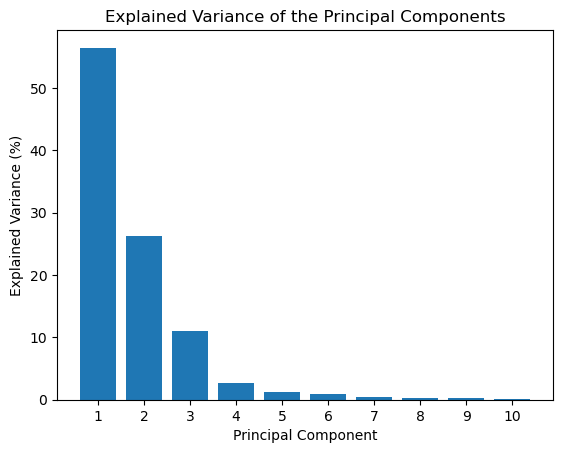

In [107]:
# barplot of explained variance of the first 10 components (plot components as integer)
components = [str(i+1) for i in range(10)]
plt.bar(components, explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance of the Principal Components')
plt.show()

In [108]:
#finalDf = pd.concat([principalDf, pd.DataFrame(df_meta, columns = ['wine'])], axis = 1)
finalDf = pd.concat([principalDf, pd.DataFrame(df_meta)], axis = 1)


In [109]:
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,bio_1,bio_12,bio_13-14,bio_15,bio_4,bio_7,clay_15-30cm_mean_0.01_deg,nitrogen_15-30cm_mean_0.01_deg,sand_15-30cm_mean_0.01_deg,soc_15-30cm_mean_0.01_deg
0,-46.871346,17.976994,-28.159374,-1.713771,-4.692588,-1.115776,-1.477180,0.922372,-1.316940,-1.267144,...,26.630093,2345.3645,349.6089,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
1,-55.874901,-7.640554,20.136921,-15.792997,-5.489915,-0.149127,1.712521,0.366869,0.934506,-0.034132,...,26.630093,2345.3645,349.6089,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
2,-49.484566,23.436308,-20.872984,-5.965938,-7.103369,-0.355502,-1.010630,0.878577,-1.715914,0.380119,...,26.630093,2345.3645,349.6089,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
3,-19.237799,10.612471,-17.371273,-5.070289,-3.067410,-1.969893,0.614468,1.513795,-0.406124,-0.739822,...,26.630093,2345.3645,349.6089,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0
4,-24.254829,5.050278,-16.099777,-2.424303,-0.556309,-0.377227,-0.860566,0.086445,-0.985678,-0.567108,...,26.630093,2345.3645,349.6089,63.548874,55.123344,7.373777,368.0,370.0,319.0,615.0


In [110]:
# write PCA axis and traits to .csv
# Create a DataFrame from your array
#df = pd.DataFrame(finalDf)
# Save the DataFrame to a CSV file
finalDf.to_csv(model_out_dir + 'embedding_pca.csv', index=False, header=True , sep=',')

### PCA-based simulation of spectra

In [111]:
# Get the PCA coordinates for the original data
pca_coordinates = pca.transform(x)

In [112]:
def pca_sim_spectra(pca_object, pca_coordinates):
        pca = pca_object
        simulated_data = np.dot(pca_coordinates, pca.components_) + pca.mean_
        sim = standardizer.inverse_transform(simulated_data)
        return sim

In [113]:
def pca_sim_coord(pca_coordinates, sel_columns, n_sample):
    # create a empty data frame with as many columns as pca_coordinates and n_sample rows
    #sim_df = pd.DataFrame(np.random.rand(n_sample, pca_coordinates.shape[1]))
    sim_df = pd.DataFrame(np.zeros((n_sample, pca_coordinates.shape[1]), dtype=float))


#fill each column with the mean value of the respective column in pca_coordinates
    for i in range(pca_coordinates.shape[1]):
        sim_df.iloc[:, i] = np.mean(pca_coordinates[:, i])


#for each value in columns, sample the values
    for i in sel_columns:
        # sample an equal interval of the last column of principalDf of length 10
        sample = np.linspace(principalDf.iloc[:, -1].quantile(0.0001), principalDf.iloc[:, -1].quantile(0.9999), num=n_sample)
        sim_df.iloc[:, i] = sample
    return sim_df

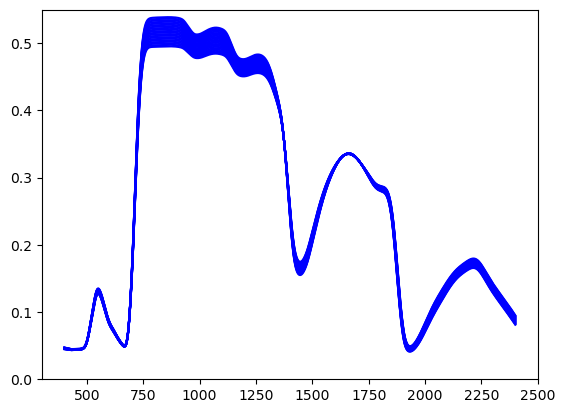

In [114]:
specsim = pca_sim_spectra(pca, pca_sim_coord(pca_coordinates, [1], 20))
# plot all spectra within 1 plot
plt.plot(range(400,2401),specsim.T, color='blue', alpha=1)
plt.ylim(0, 0.55)
plt.show()

In [115]:
#for each pca_componment, simulate the 20 spectra and write it to a pandas dataframe, where and index tracks the number of the component
for pca_component in range(0, 10):
    specsim = pca_sim_spectra(pca, pca_sim_coord(pca_coordinates, [pca_component], 20))
    specsim = pd.DataFrame(specsim)
    specsim.to_csv(model_out_dir + 'simulated_spectra_pca_comp_' + str(pca_component+1) + '.csv', index=False, header=True , sep=',')

#specsim = pca_sim_spectra(pca, pca_sim_coord(pca_coordinates, [pca_component, 20))

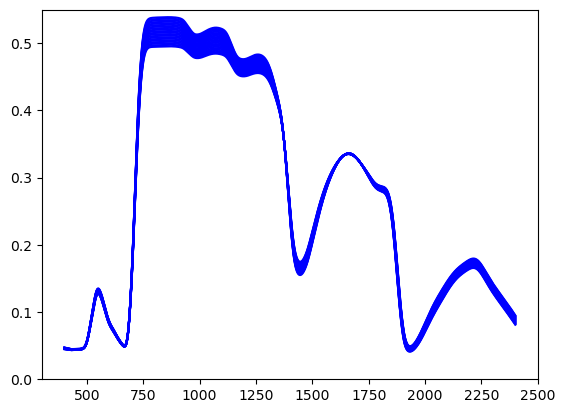

In [116]:
# open simulated_spectra_pca_comp_1 and plot the 20 spectra
sim = pd.read_csv(model_out_dir + 'simulated_spectra_pca_comp_2.csv')
plt.plot(range(400,2401),sim.T, color='blue', alpha=1)
plt.ylim(0, 0.55)
plt.show()


### Check the PCA reconstruction quality

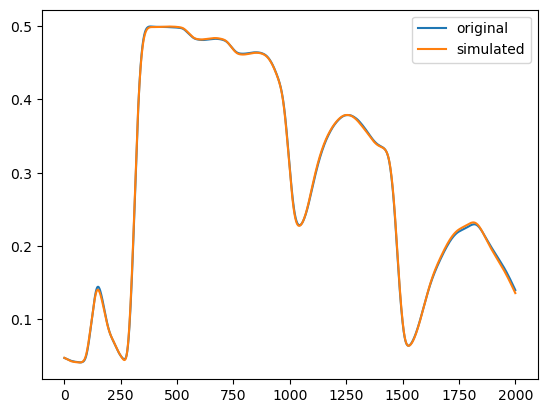

In [117]:

# Now we can simulate new data based on these PCA coordinates
simulated_data = np.dot(pca_coordinates, pca.components_) + pca.mean_
x_tr = standardizer.inverse_transform(x)
sim_tr = standardizer.inverse_transform(simulated_data)

# select a random integer at the length of the dataset
random_int = random.randint(0, len(x_tr))

plt.plot(x_tr[random_int], label = 'original')
plt.plot(sim_tr[random_int], label = 'simulated')

# add legend
plt.legend()
plt.show()

# Dimension reduction via variational autoencoder

In [118]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

In [119]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.meta = load_data(path)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index]
    def __len__(self):
        return self.len

## Implement variational autoencoder architecture and train model

In [120]:
class Autoencoder(nn.Module):
    def __init__(self, D_in, H1=256, H2=128, H3=64, H4=32, latent_dim=5):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.linear1 = nn.Linear(D_in, H1)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H1)
        self.linear2 = nn.Linear(H1, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H3)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H3)
        self.linear4 = nn.Linear(H3, H4)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H4)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H4, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H4)
        self.fc_bn4 = nn.BatchNorm1d(H4)

        # Decoder
        self.linear5 = nn.Linear(H4, H3)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H3)
        self.linear6 = nn.Linear(H3, H2)
        self.lin_bn6 = nn.BatchNorm1d(num_features=H2)
        self.linear7 = nn.Linear(H2, H1)
        self.lin_bn7 = nn.BatchNorm1d(num_features=H1)
        self.linear8 = nn.Linear(H1, D_in)
        self.lin_bn8 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        lin4 = self.relu(self.lin_bn4(self.linear4(lin3)))

        fc1 = self.relu(self.bn1(self.fc1(lin4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin5 = self.relu(self.lin_bn5(self.linear5(fc4)))
        lin6 = self.relu(self.lin_bn6(self.linear6(lin5)))
        lin7 = self.relu(self.lin_bn7(self.linear7(lin6)))
        return self.lin_bn8(self.linear8(lin7))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), z, mu, logvar

In [121]:
############ Loss functions ##

# class customLoss(nn.Module):
#     def __init__(self):
#         super(customLoss, self).__init__()
#         self.mse_loss = nn.MSELoss(reduction="sum")

#     # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar
#     def forward(self, x_recon, x, mu, logvar):
#         loss_MSE = self.mse_loss(x_recon, x)
#         loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#         return loss_MSE + loss_KLD



# class mseLoss(nn.Module):
#     def __init__(self):
#         super(mseLoss, self).__init__()
#         self.mse_loss = nn.MSELoss(reduction="sum")
#         #self.mse_loss = nn.L1Loss(reduction="sum")

#     # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar
#     def forward(self, x_recon, x):
#         loss_MSE = self.mse_loss(x_recon, x)

#         return loss_MSE
    

class mseLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(mseLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        self.cosine_loss = nn.CosineEmbeddingLoss()
        self.alpha = alpha  # This is the weight for the MSE loss

    def forward(self, x_recon, x):
        loss_MSE = self.mse_loss(x_recon, x)
        # CosineEmbeddingLoss expects inputs to be in the shape (batch_size, dim) and a target of size (batch_size) with values 1 or -1
        x_recon = x_recon.view(x_recon.size(0), -1)
        x = x.view(x.size(0), -1)
        target = x.new_ones(x.size(0))  # All target values are 1
        loss_cosine = self.cosine_loss(x_recon, x, target)

        return self.alpha * loss_MSE + (1 - self.alpha) * loss_cosine
    


class KLDLoss(nn.Module):
    def __init__(self):
        super(KLDLoss, self).__init__()

    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar
    def forward(self, mu, logvar):
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_KLD

In [122]:
####### Decoupling losses #####

class decouplingLoss(nn.Module):
    def __init__(self):
        super(decouplingLoss, self).__init__()

    def forward(self, mu, logvar):
        # Compute the covariance matrix of the latent variables
        mu_centered = mu - mu.mean(dim=0)
        cov_matrix = mu_centered.t().mm(mu_centered) / mu_centered.size(0)

        # Add the sum of the off-diagonal elements to the loss
        loss_cov = cov_matrix.sum() - torch.diag(cov_matrix).sum()
        return loss_cov

def total_correlation(z, mu, logvar):
    # Flatten z if necessary
    if len(z.size()) > 2:
        z = z.view(z.size(0), -1)

    log_qz = log_density_gaussian(z, mu, logvar)
    log_qz_product = log_qz.sum(1, keepdim=True)
    log_qz_sum = log_qz.sum(0, keepdim=True)
    tc = (log_qz_sum - log_qz_product).mean()
    return tc

def log_density_gaussian(x, mu, logvar):
    c = torch.log(torch.tensor(2. * torch.pi))
    var = torch.exp(logvar)
    log_density = -0.5 * (c + logvar + ((x - mu) ** 2) / var)
    return log_density

In [123]:
# # takes in a module and applies the specified weight initialization
# def weights_init_uniform_rule(m):
#     classname = m.__class__.__name__
#     # for every Linear layer in a model..
#     if classname.find('Linear') != -1:
#         # get the number of the inputs
#         n = m.in_features
#         y = 1.0/np.sqrt(n)
#         m.weight.data.uniform_(-y, y)
#         m.bias.data.fill_(0)

# Train

In [124]:
#### epoch training process #####

def train(epoch, loss_best):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        # recon_batch, mu, logvar = model(data)
        recon_batch, z, mu, logvar = model(data)

        # loss = loss_mse(recon_batch, data, mu, logvar)

        loss_kld_ = loss_kld(mu, logvar)
        # print(loss_kld_.item())

        loss_mse_ = loss_mse(recon_batch, data) / recon_batch.shape[0]
        # print(loss_mse_.item())

        # Decoupling Loss (Total Correlation)
        # z = model.sample_latent(mu, logvar)  # Assuming your model has a method to sample from the latent space
        loss_tc_ = total_correlation(z, mu, logvar)
        # print(loss_tc_.item())
        # loss_decouple_ = loss_decouple(mu, logvar)
        # print(loss_decouple_.item())

        loss = loss_kld_ + lambda_* loss_mse_ + loss_tc_/2 #loss_decouple_
        # print(loss.item())

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        #### log step metrics to wandb ###
        metrics_per_step = {'train_step/train_loss': loss.item()}
        metrics_per_step.update({'train_step/train_loss_mse_': loss_mse_.item()})
        metrics_per_step.update({'train_step/train_loss_kld': loss_kld_.item()})
        metrics_per_step.update({'train_step/train_loss_tc': loss_tc_.item()})
        wandb.log(metrics_per_step) #, step=batch_idx+1

    # safe model if loss is better than before
    loss_epoch = train_loss / len(trainloader)
    train_losses.append(loss_epoch)
    # print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss_epoch))

    #### log epoch metrics to wandb ###
    metrics_per_step = {'train_epoch/train_loss': loss_epoch}
    wandb.log(metrics_per_step) #, step=batch_idx+1

    # global loss_best
    if loss_best > loss_epoch:
        #safe model
        torch.save(model.state_dict(), model_out_dir + 'model.pth')
            # restore mode: model.load_state_dict(torch.load(model_out_dir + 'model.pth'))
        # write loss to txt file
        with open(model_out_dir + 'loss.txt', 'w') as f:
            f.write('loss: {}'.format(loss_epoch))
        loss_best = loss_epoch

    if epoch % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss_epoch))
        with open(model_out_dir + 'losses.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            for loss in train_losses:
                writer.writerow([loss])

In [125]:
######### Experiment settings ###
epochs = 30000
log_interval = 50

val_losses = []
train_losses = []

global loss_best
loss_best = float(1000000) # loss value for initlization

D_in = x.shape[1] #data_set.x.shape[1]
H1 = 256 #hidden_dim1 (50)
H2 = 128 #hidden_dim2 (12)
H3 = 64
H4 = 32

latent_dim=10

lambda_ = 1 #1e-2
lr = 1e-4

# set the batch size
batch_size_train = 128

if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

In [126]:
###### model initialization ##

wandb.init(project='Spectra_VAE') ## wandb logging

data_set = DataBuilder(data_path)
trainloader = DataLoader(dataset = data_set, batch_size = batch_size_train, shuffle=True)
evalloadder = DataLoader(dataset = data_set, batch_size = batch_size_train, shuffle=False)

model = Autoencoder(D_in, H1=H1, H2=H2, H3=H3, H4=H4, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

loss_kld = KLDLoss()
loss_mse = mseLoss()
loss_decouple = decouplingLoss()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: teja-kattenborn (geosense). Use `wandb login --relogin` to force relogin


In [127]:
for epoch in range(1, epochs + 1):
    train(epoch, loss_best)

====> Epoch: 50 Average loss: 571.0808
====> Epoch: 100 Average loss: 493.3359
====> Epoch: 150 Average loss: 449.4696
====> Epoch: 200 Average loss: 443.1253
====> Epoch: 250 Average loss: 444.3676
====> Epoch: 300 Average loss: 438.6062
====> Epoch: 350 Average loss: 437.3197
====> Epoch: 400 Average loss: 445.2581
====> Epoch: 450 Average loss: 436.3865
====> Epoch: 500 Average loss: 440.7513
====> Epoch: 550 Average loss: 434.5018
====> Epoch: 600 Average loss: 435.3494
====> Epoch: 650 Average loss: 435.9200
====> Epoch: 700 Average loss: 436.7061
====> Epoch: 750 Average loss: 435.7762
====> Epoch: 800 Average loss: 436.0792
====> Epoch: 850 Average loss: 432.6332
====> Epoch: 900 Average loss: 433.0433
====> Epoch: 950 Average loss: 435.7574
====> Epoch: 1000 Average loss: 430.8604
====> Epoch: 1050 Average loss: 428.0301
====> Epoch: 1100 Average loss: 434.1024
====> Epoch: 1150 Average loss: 432.5204
====> Epoch: 1200 Average loss: 430.1127
====> Epoch: 1250 Average loss: 433.

KeyboardInterrupt: 

# Evaluate the autoencoder

In [227]:
model.load_state_dict(torch.load(model_out_dir + 'model.pth'))

<All keys matched successfully>

In [ ]:
#standardizer = trainloader.dataset.standardizer

In [228]:
recon_batches = []
data_batches = []
mu_batches = []
with torch.no_grad():
    for i, data in enumerate(evalloadder):
        recon_batch, z, mu, logvar = model(data)
        data = data.to(device)
        mu_batches.append(mu)
        data_batches.append(data)
        recon_batches.append(recon_batch)

recon = torch.cat((recon_batches), dim = 0)
data = torch.cat((data_batches), dim = 0)
mu = torch.cat((mu_batches), dim = 0)

In [191]:
mu

tensor([[-2.1417e-04,  4.1650e-03,  4.7267e-04,  ..., -2.0035e-03,
          9.6267e-01,  2.2404e-04],
        [-1.4355e-03,  4.0495e-03, -1.3548e-02,  ...,  5.8980e-03,
          1.6643e+00,  1.4043e-03],
        [ 1.6294e-04,  2.8557e-03,  1.7506e-03,  ..., -2.9254e-03,
          1.0538e+00, -1.8114e-03],
        ...,
        [-3.1304e-03, -3.6565e-03,  5.7339e-03,  ...,  2.7540e-03,
         -6.8939e-01, -1.0214e-03],
        [-2.8828e-03,  5.2026e-04, -3.3236e-04,  ...,  2.4351e-03,
          2.3584e-01,  4.3287e-04],
        [-7.1429e-03, -7.5285e-03,  3.4914e-03,  ...,  3.6110e-03,
         -1.0120e+00,  2.3414e-03]], device='cuda:0')

In [229]:
standardized_recon = standardizer.inverse_transform(recon.cpu().numpy())
standardized_data = standardizer.inverse_transform(data.cpu().numpy())
print("recon shape", standardized_recon.shape)
print("data shape", standardized_data.shape)
print("mu shape", mu.shape)

recon shape (6181, 2001)
data shape (6181, 2001)
mu shape torch.Size([6181, 10])


In [230]:
# select those column names that represent a value between 400 and 2500
spectracols = [col for col in df.columns if col.isdigit() and 400 <= int(col) <= 2500]
# convert the list of str to an int vector
spectraindex = [int(col) for col in spectracols]

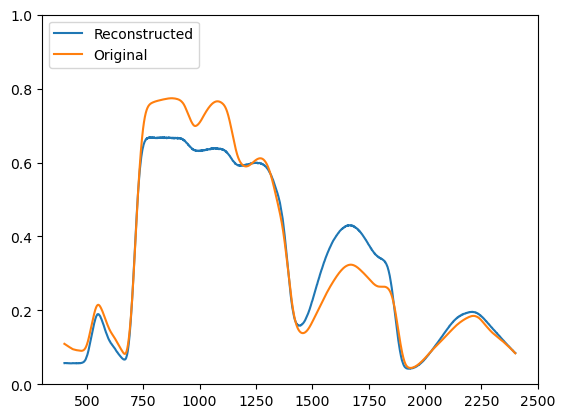

In [231]:
# Get the number of rows
num_rows = data.shape[0]

# Sample an index value within the number of rows
index = random.randint(0, num_rows-1)
plt.plot(spectraindex, standardized_recon[index], label='Reconstructed')
plt.plot(spectraindex, standardized_data[index], label='Original')
plt.ylim(0, 1)
plt.legend(loc='upper left')  # Add a legend
plt.show()

## Load and apply new data
... to be prepared

In [ ]:
#data_set2=DataBuilder(DATA_PATH)
#inferenceloader=DataLoader(dataset=data_set2,batch_size=1)

In [ ]:
#with torch.no_grad():
#    for i, data in enumerate(inferenceloader):
#        data_inf = data.to(device)
#        recon_batch, mu, logvar = model(data_inf)

# what about the standardizer?

## Apply the autoencoder to (heuristic) encodings

In [232]:
# apply the decoder of the variaitonal autoencoder to some heuristic latent space values
# and plot the resulting spectra
model.load_state_dict(torch.load(model_out_dir + 'model.pth'))
model.eval()
with torch.no_grad():
    z = torch.tensor([[2.53, 0.28, 1.123, 5.28, 8.123]]).to(device)
    sample = model.decode(z).cpu()
    sample = sample.numpy()
    sample = standardizer.inverse_transform(sample)
    plt.plot(spectraindex, sample[0], label = 'sample')
    plt.legend(loc = 'upper right')
    plt.ylim(0, 1)
    plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 10x10)

# Get Embeddings

In [233]:
# write emebddings to csv
#numpy_array = mu_result.numpy()

#np.savetxt(model_out_dir + 'embedding_train.csv', numpy_array, delimiter=',')

# write embeddings and traits to .csv
embeddings = pd.DataFrame(mu.cpu().numpy())
finalDf_vae = pd.concat([embeddings, pd.DataFrame(df_meta)], axis = 1)
finalDf_vae.to_csv(model_out_dir + 'embedding_vae.csv', index=False, header=True , sep=',')


# Basic plotting of the dimension reduction

## Plot Embeddings of PCA

In [234]:
from mpl_toolkits import mplot3d

# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### continuous variable

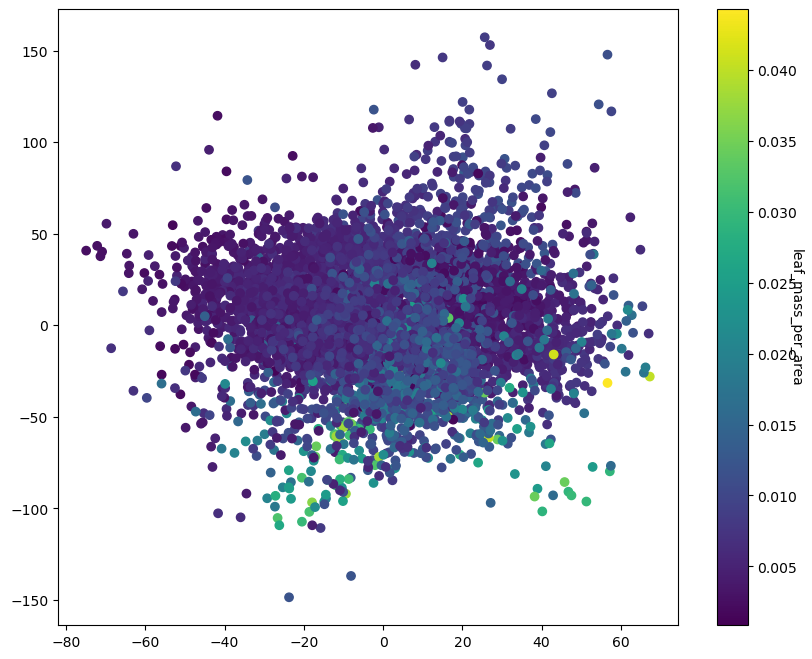

In [235]:
from sklearn.preprocessing import LabelEncoder

# Data for three-dimensional scattered points
variable = 'leaf_mass_per_area'

filteredDf = finalDf[finalDf[variable] != -99]

metatype = filteredDf['leaf_mass_per_area'].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111)

zdata = filteredDf.iloc[:,0].values
xdata = filteredDf.iloc[:,1].values
sc = ax.scatter(xdata, zdata, c=metatype, cmap='viridis')

cbar = plt.colorbar(sc)
cbar.set_label('leaf_mass_per_area', rotation=270)

plt.show()


## Plot embeddings of autoencoder

### discrete variable

### continuous variable

In [ ]:
mu

tensor([[ 2.8026e-45, -2.8026e-45,  2.8026e-45, -2.8026e-45,  2.8026e-45],
        [ 2.8026e-45, -2.8026e-45,  2.8026e-45, -2.8026e-45,  2.8026e-45],
        [ 2.8026e-45, -2.8026e-45,  2.8026e-45, -2.8026e-45,  2.8026e-45],
        ...,
        [ 2.8026e-45, -2.8026e-45,  2.8026e-45, -2.8026e-45,  2.8026e-45],
        [ 2.8026e-45, -2.8026e-45,  2.8026e-45, -2.8026e-45,  2.8026e-45],
        [ 2.8026e-45, -2.8026e-45,  2.8026e-45, -2.8026e-45,  2.8026e-45]],
       device='cuda:0')

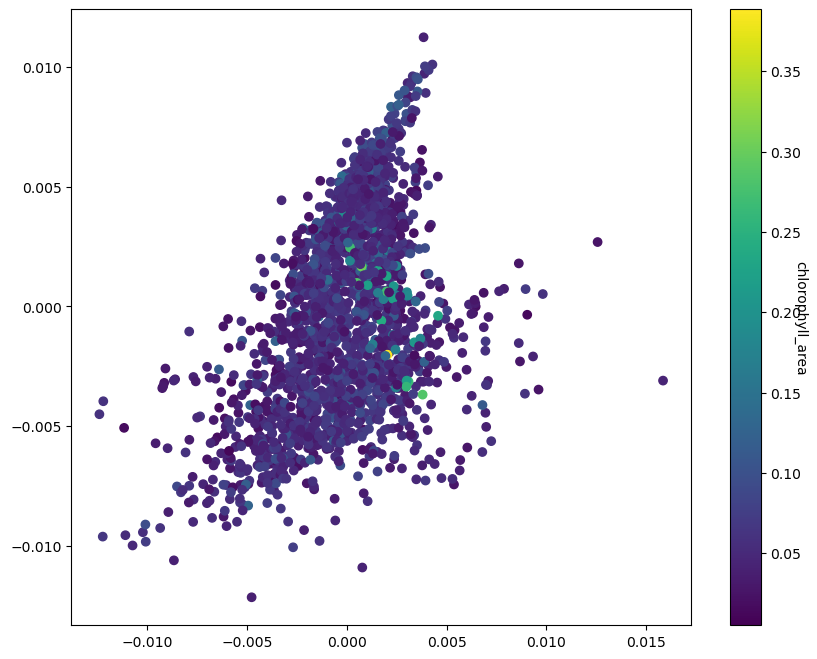

In [236]:
# Data for three-dimensional scattered points
# Data for three-dimensional scattered points

# Assuming finalDf is your DataFrame
#filteredDf = finalDf[(finalDf != -99).all(axis=1)]
#filteredmu_result = mu_result[(finalDf != -99).all(axis=1)]

variable = 'chlorophyll_area'
#variable = 'equivalent_water_thickness'

filteredDf = finalDf[finalDf[variable] != -99]
filteredmu_result = mu[finalDf[variable] != -99]

metatype = filteredDf[variable].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111)

ydata = filteredmu_result[:,1].cpu().numpy()
xdata = filteredmu_result[:,0].cpu().numpy()
sc = ax.scatter(xdata, ydata, c=metatype, cmap='viridis');

cbar = plt.colorbar(sc)
cbar.set_label('chlorophyll_area', rotation=270)
#cbar.set_label('equivalent_water_thickness', rotation=270)

plt.show()

## trash bin

In [182]:
df_meta.columns

Index(['carbon_area', 'carbon_mass', 'Jmax', 'latin_genus', 'latin_species',
       'leaf_mass_per_area', 'nitrogen_area', 'nitrogen_mass', 'Rd', 'Vcmax',
       'leaf_dry_matter_content', 'equivalent_water_thickness', 'latitude',
       'longitude', 'dataset', 'Unnamed: 2016', 'species_name',
       'chlorophyll_area', 'chlorophyll_mass', 'carotenoids_area',
       'carotenoids_mass', 'phenolics_mass', 'phenolics_area', 'solubles_mass',
       'hemicellulose_mass', 'cellulose_mass', 'lignin_mass', 'aluminum_mass',
       'boron_mass', 'calcium_mass', 'copper_mass', 'iron_mass',
       'potassium_mass', 'magnesium_mass', 'manganese_mass', 'sodium_mass',
       'phosphorus_mass', 'zinc_mass', 'solubles_area', 'hemicellulose_area',
       'cellulose_area', 'lignin_area', 'aluminum_area', 'calcium_area',
       'copper_area', 'iron_area', 'potassium_area', 'magnesium_area',
       'manganese_area', 'sodium_area', 'phosphorus_area', 'zinc_area',
       'boron_area', 'bio_1', 'bio_12', 'bio